<a href="https://colab.research.google.com/github/JacoboCamargo/Parcial-2-IA/blob/main/Parcial_2_HE2_Inteligencia_Artificial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## PARCIAL 2 IA ##

In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)
import pickle

In [ ]:
# Punto 1.1
import requests
import pandas as pd

# URLs de los archivos del dataset
dataset_urls = {
    "adult.names": "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
    "adult.data": "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    "adult.test": "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
}

# Descargar los archivos del dataset
for fname, link in dataset_urls.items():
    try:
        res = requests.get(link)
        res.raise_for_status()  # Lanza error para respuestas 4xx/5xx
        with open(fname, "w") as file:
            file.write(res.text)
        print(f"{fname} descargado correctamente.")
    except requests.exceptions.RequestException as err:
        print(f"Fallo al descargar {fname}: {err}")
        # Aquí podrías decidir omitir el archivo o detener el flujo

# Leer el archivo de nombres para extraer columnas
with open("adult.names", "r") as file:
    raw_lines = file.readlines()

# Extraer nombres de columnas ignorando comentarios
columns = []
for line in raw_lines:
    if ":" in line and not line.strip().startswith("|"):
        col = line.split(":")[0].strip()
        columns.append(col)

# Añadir la columna objetivo manualmente
columns.append("income")

print("Columnas detectadas:")
print(columns)

# -------------------------
# Cargar dataset de entrenamiento
# -------------------------
train_df = pd.read_csv(
    "adult.data",
    header=None,
    names=columns,
    na_values=[" ?", "?"],
    sep=",\s*",
    skipinitialspace=True
)

# -------------------------
# Cargar dataset de prueba
# -------------------------
test_df = pd.read_csv(
    "adult.test",
    header=0,
    names=columns,
    na_values=[" ?", "?"],
    sep=",\s*",
    skipinitialspace=True,
    comment="|"
)

# Corregir valores en la columna 'income' del test (remover punto final)
test_df["income"] = test_df["income"].str.replace(".", "", regex=False).str.strip()

# Mostrar dimensiones de los datasets
print("Dimensión del entrenamiento:", train_df.shape)
print("Dimensión del test:", test_df.shape)

# Vista preliminar del train
train_df.head()


<>:49: SyntaxWarning: invalid escape sequence '\s'
<>:61: SyntaxWarning: invalid escape sequence '\s'
<>:49: SyntaxWarning: invalid escape sequence '\s'
<>:61: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1042940310.py:49: SyntaxWarning: invalid escape sequence '\s'
  sep=",\s*",
/tmp/ipython-input-1042940310.py:61: SyntaxWarning: invalid escape sequence '\s'
  sep=",\s*",


adult.names descargado correctamente.
adult.data descargado correctamente.
adult.test descargado correctamente.
Columnas detectadas:
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']


/tmp/ipython-input-1042940310.py:44: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_df = pd.read_csv(
/tmp/ipython-input-1042940310.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_df = pd.read_csv(


Dimensión del entrenamiento: (32561, 15)
Dimensión del test: (16280, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
# Punto 1.2

from sklearn.model_selection import train_test_split

# Dividir el conjunto de prueba en validación (50%) y prueba final (50%)
val_set, test_set_final = train_test_split(
    test_df,
    test_size=0.5,
    random_state=42,
    stratify=test_df["income"]  # preserva la proporción de clases en ambas divisiones
)

print("Tamaño del conjunto de validación:", val_set.shape)
print("Tamaño del conjunto de prueba final:", test_set_final.shape)


Tamaño del conjunto de validación: (8140, 15)
Tamaño del conjunto de prueba final: (8140, 15)


In [ ]:
# Punto 1.3

# Información general del conjunto de entrenamiento
print("Resumen de información del dataset:")
print(train_df.info())

# Estadísticas descriptivas, incluyendo variables categóricas
print("\nEstadísticas descriptivas:")
print(train_df.describe(include="all"))

# Comprobación de valores faltantes
print("\nCantidad de valores nulos por columna:")
print(train_df.isnull().sum())

# Distribución de la variable objetivo ('income')
print("\nDistribución proporcional de la variable objetivo:")
print(train_df["income"].value_counts(normalize=True))


Resumen de información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None

Estadísticas descriptivas:
                 age wor

In [ ]:
# Tratamiento de valores faltantes

# Opción 1: eliminar filas con valores nulos
# (comentado para no perder datos)
# train_df = train_df.dropna()
# val_set = val_set.dropna()
# test_set_final = test_set_final.dropna()

# Opción 2: reemplazar NaN por "Unknown"
# Ventaja: no se descartan datos; el modelo puede aprender que "Unknown" es una categoría posible.
for col in ["workclass", "occupation", "native-country"]:
    train_df[col] = train_df[col].fillna("Unknown")


In [ ]:
# Punto 1.4 – Preprocesamiento de los datos

# Crear copias para preservar los originales
train_processed = train_df.copy()
val_processed = val_set.copy()
test_processed = test_set_final.copy()

# Codificar la variable objetivo ('income')
# Se asigna 0 a ingresos <=50K y 1 a ingresos >50K
income_mapping = {"<=50K": 0, ">50K": 1, "<=50K.": 0, ">50K.": 1}
for df in [train_processed, val_processed, test_processed]:
    df["income"] = df["income"].map(income_mapping)

# Identificar columnas categóricas y numéricas
categorical_features = train_processed.select_dtypes(include=["object"]).columns.tolist()
numeric_features = train_processed.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_features.remove("income")  # Excluir la variable target

# One-hot encoding para variables categóricas
# Ventaja: evita que el modelo interprete orden donde no lo hay
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ohe.fit(train_processed[categorical_features])  # Solo entrenar con train

# Aplicar transformación a las particiones
train_cat = ohe.transform(train_processed[categorical_features])
val_cat   = ohe.transform(val_processed[categorical_features])
test_cat  = ohe.transform(test_processed[categorical_features])

# Normalización de variables numéricas
scaler = StandardScaler()
scaler.fit(train_processed[numeric_features])  # Solo con train para evitar data leakage

train_num = scaler.transform(train_processed[numeric_features])
val_num   = scaler.transform(val_processed[numeric_features])
test_num  = scaler.transform(test_processed[numeric_features])

# Concatenar variables numéricas y categóricas procesadas
X_train = np.hstack([train_num, train_cat])
X_val   = np.hstack([val_num, val_cat])
X_test  = np.hstack([test_num, test_cat])

# Separar los targets
y_train = train_processed["income"].values
y_val   = val_processed["income"].values
y_test  = test_processed["income"].values

# Obtener nombres de las nuevas columnas (post OneHot y normalización)
categorical_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + categorical_feature_names.tolist()

# Convertir a DataFrames para facilitar inspección
X_train_df = pd.DataFrame(X_train, columns=all_feature_names)
X_val_df   = pd.DataFrame(X_val, columns=all_feature_names)
X_test_df  = pd.DataFrame(X_test, columns=all_feature_names)

print("Shape de X_train:", X_train_df.shape)
print("\nVista previa de datos procesados:")
print(X_train_df.head())



Shape de X_train: (32561, 108)

Vista previa de datos procesados:
        age    fnlwgt  education-num  capital-gain  capital-loss  \
0  0.030671 -1.063611       1.134739      0.148453      -0.21666   
1  0.837109 -1.008707       1.134739     -0.145920      -0.21666   
2 -0.042642  0.245079      -0.420060     -0.145920      -0.21666   
3  1.057047  0.425801      -1.197459     -0.145920      -0.21666   
4 -0.775768  1.408176       1.134739     -0.145920      -0.21666   

   hours-per-week  workclass_Federal-gov  workclass_Local-gov  \
0       -0.035429                    0.0                  0.0   
1       -2.222153                    0.0                  0.0   
2       -0.035429                    0.0                  0.0   
3       -0.035429                    0.0                  0.0   
4       -0.035429                    0.0                  0.0   

   workclass_Never-worked  workclass_Private  ...  native-country_Puerto-Rico  \
0                     0.0                0.0  ...    

In [ ]:
# Punto 2.1 – Baseline con Regresión Logística
# ============================================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# Modelo de regresión logística (baseline)
# Usamos 'liblinear' por compatibilidad y eficiencia en datasets pequeños
log_model = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="liblinear",
    max_iter=500
)
log_model.fit(X_train, y_train)

# Función para evaluar el modelo en un dataset dado
def evaluate_model(model, X, y_true, split_label):
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    results = {
        "split": split_label,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba)
    }

    conf_matrix = confusion_matrix(y_true, y_pred)
    return results, conf_matrix

# Evaluaciones
train_metrics, train_cm = evaluate_model(log_model, X_train, y_train, "train")
val_metrics,   val_cm   = evaluate_model(log_model, X_val,   y_val,   "val")
test_metrics,  test_cm  = evaluate_model(log_model, X_test,  y_test,  "test")

# Consolidar métricas en un DataFrame
metrics_summary = pd.DataFrame([train_metrics, val_metrics, test_metrics])

# Resultados
print("✅ Punto 2.1 completado")
print(metrics_summary)

print("\nMatrices de confusión (formato: [[tn, fp], [fn, tp]]):")
print("Entrenamiento:\n", train_cm)
print("Validación:\n", val_cm)
print("Prueba:\n", test_cm)

# ===============================
# Guardar artefactos (opcional)
# ===============================

# from pathlib import Path
# import pickle
# import numpy as np

# Path("/mnt/data").mkdir(exist_ok=True)
# with open("/mnt/data/logreg_baseline.pkl", "wb") as f:
#     pickle.dump(log_model, f)

# np.savez("/mnt/data/logreg_conf_mats.npz", cm_train=train_cm, cm_val=val_cm, cm_test=test_cm)

# print("\nArtefactos guardados:")
# print("- /mnt/data/logreg_baseline.pkl")
# print("- /mnt/data/logreg_conf_mats.npz")


✅ Punto 2.1 completado
   split  accuracy  precision    recall        f1   roc_auc
0  train  0.853106   0.738088  0.604515  0.664657  0.908713
1    val  0.848649   0.717981  0.591784  0.648803  0.901748
2   test  0.857125   0.737500  0.613625  0.669884  0.908121

Matrices de confusión (formato: [[tn, fp], [fn, tp]]):
Entrenamiento:
 [[23038  1682]
 [ 3101  4740]]
Validación:
 [[5770  447]
 [ 785 1138]]
Prueba:
 [[5797  420]
 [ 743 1180]]


In [ ]:
# Punto 2.2 – Preparación para modelo de Redes Neuronales

# Asegurar que todos los arrays tengan el tipo correcto para PyTorch o TensorFlow
X_train = X_train_df.values.astype(np.float32)
y_train = train_processed["income"].values.astype(np.int64)

X_val   = X_val_df.values.astype(np.float32)
y_val   = val_processed["income"].values.astype(np.int64)

X_test  = X_test_df.values.astype(np.float32)
y_test  = test_processed["income"].values.astype(np.int64)  # <- corregido (antes decía y_text)


In [ ]:
# Punto 2.2 – Configuración de entorno para entrenamiento con PyTorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
import matplotlib.pyplot as plt
import time
import copy

# Selección del dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo seleccionado:", device)

# Mostrar detalles de la GPU (si aplica)
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU disponible: {gpu_name}")
    print(f"Memoria total de GPU: {gpu_memory:.2f} GB")


Dispositivo seleccionado: cuda
GPU disponible: Tesla T4
Memoria total de GPU: 15.83 GB


In [ ]:
# Punto 2.2.1 – Arquitectura base de la red neuronal (MLP)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=[128, 64], dropout=0.5):
        super().__init__()

        layers = []
        in_features = input_dim

        for hidden_units in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(nn.ReLU())

            # Dropout: durante el entrenamiento, apaga aleatoriamente una fracción de neuronas
            if dropout > 0:
                layers.append(nn.Dropout(dropout))

            in_features = hidden_units  # Para la siguiente capa

        # Capa de salida: 1 unidad (para clasificación binaria con sigmoid más adelante)
        layers.append(nn.Linear(in_features, 1))

        # Usamos nn.Sequential para encadenar todas las capas
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # Salida sin activación final (logits), se usará BCEWithLogitsLoss
        return self.net(x).squeeze(1)


In [ ]:
# Punto 2.2.2 – Función de pérdida y optimizador

import torch.optim as optim

# Inicializar el modelo
input_dim = X_train.shape[1]  # Número total de features (numéricos + one-hot)
model = MLP(input_dim, hidden_layers=[128, 64], dropout=0.5)

# Enviar el modelo al dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --------------------------------------------------
# Revisión del balance de clases en cada partición
# --------------------------------------------------

print("Distribución de clases por conjunto:\n")

print("Train (cuentas absolutas):")
print(train_processed["income"].value_counts())

print("\nValidation (cuentas absolutas):")
print(val_processed["income"].value_counts())

print("\nTest (cuentas absolutas):")
print(test_processed["income"].value_counts())

print("\nTrain (proporciones):")
print(train_processed["income"].value_counts(normalize=True))

print("\nValidation (proporciones):")
print(val_processed["income"].value_counts(normalize=True))

print("\nTest (proporciones):")
print(test_processed["income"].value_counts(normalize=True))

# --------------------------------------------------
# Ponderación para clases desbalanceadas
# --------------------------------------------------

# Calcular el peso relativo de la clase positiva
num_pos = (y_train == 1).sum()
num_neg = (y_train == 0).sum()
pos_weight_value = num_neg / (num_pos + 1e-8)  # Evitar división por cero

pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32).to(device)

# --------------------------------------------------
# Definir función de pérdida y optimizador
# --------------------------------------------------

# BCEWithLogitsLoss = Sigmoid + Binary Cross Entropy (numéricamente estable)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Adam: buena elección por defecto (con L2 regularización incluida vía weight_decay)
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4  # L2 regularización
)


Distribución de clases por conjunto:

Train (cuentas absolutas):
income
0    24720
1     7841
Name: count, dtype: int64

Validation (cuentas absolutas):
income
0    6217
1    1923
Name: count, dtype: int64

Test (cuentas absolutas):
income
0    6217
1    1923
Name: count, dtype: int64

Train (proporciones):
income
0    0.75919
1    0.24081
Name: proportion, dtype: float64

Validation (proporciones):
income
0    0.763759
1    0.236241
Name: proportion, dtype: float64

Test (proporciones):
income
0    0.763759
1    0.236241
Name: proportion, dtype: float64


In [ ]:
# Punto 2.2.3 – Loop de entrenamiento con validación

from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# -------------------------------------
# Crear DataLoaders para entrenamiento y validación
# -------------------------------------

batch_size = 128

train_dataset = TensorDataset(
    torch.from_numpy(X_train),
    torch.from_numpy(y_train.astype(np.float32))
)

val_dataset = TensorDataset(
    torch.from_numpy(X_val),
    torch.from_numpy(y_val.astype(np.float32))
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# -------------------------------------
# Función de entrenamiento y validación
# -------------------------------------

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=50):
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, epochs + 1):
        # ---- Entrenamiento ----
        model.train()
        epoch_train_losses = []

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            epoch_train_losses.append(loss.item())

        # ---- Validación ----
        model.eval()
        epoch_val_losses = []

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                epoch_val_losses.append(loss.item())

        # ---- Guardar historial ----
        train_loss_avg = np.mean(epoch_train_losses)
        val_loss_avg = np.mean(epoch_val_losses)

        history["train_loss"].append(train_loss_avg)
        history["val_loss"].append(val_loss_avg)

        # ---- Mostrar progreso ----
        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f}")

    return history



=== Experimento 1 ===
Configuración: {'hidden_layers': [64], 'dropout': 0.0, 'lr': 0.001, 'weight_decay': 0.0, 'epochs': 50}
Epoch 1/50 - Train Loss: 0.6878 | Val Loss: 0.5893
Epoch 10/50 - Train Loss: 0.5402 | Val Loss: 0.5728
Epoch 20/50 - Train Loss: 0.5261 | Val Loss: 0.5766
Epoch 30/50 - Train Loss: 0.5149 | Val Loss: 0.5811
Epoch 40/50 - Train Loss: 0.5073 | Val Loss: 0.5866
Epoch 50/50 - Train Loss: 0.5004 | Val Loss: 0.5972


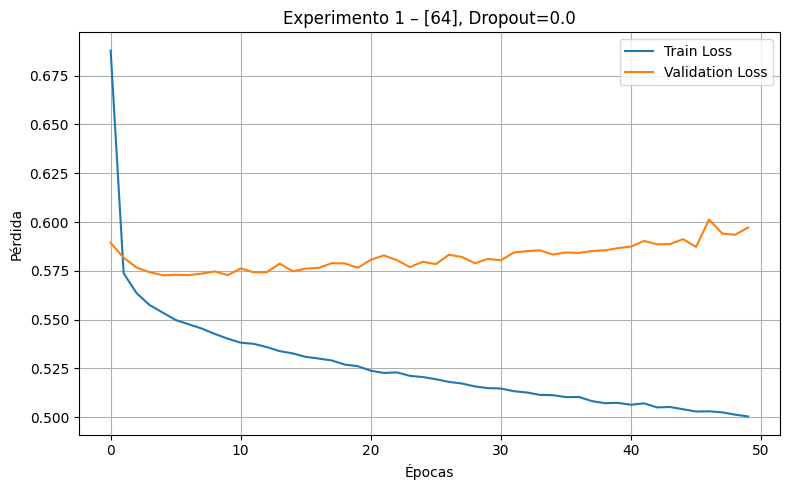


=== Experimento 2 ===
Configuración: {'hidden_layers': [128, 64], 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.0001, 'epochs': 70}
Epoch 1/70 - Train Loss: 0.6522 | Val Loss: 0.5801
Epoch 10/70 - Train Loss: 0.5395 | Val Loss: 0.5753
Epoch 20/70 - Train Loss: 0.5185 | Val Loss: 0.5772
Epoch 30/70 - Train Loss: 0.5028 | Val Loss: 0.5901
Epoch 40/70 - Train Loss: 0.4899 | Val Loss: 0.5988
Epoch 50/70 - Train Loss: 0.4784 | Val Loss: 0.6228
Epoch 60/70 - Train Loss: 0.4700 | Val Loss: 0.6442
Epoch 70/70 - Train Loss: 0.4601 | Val Loss: 0.6342


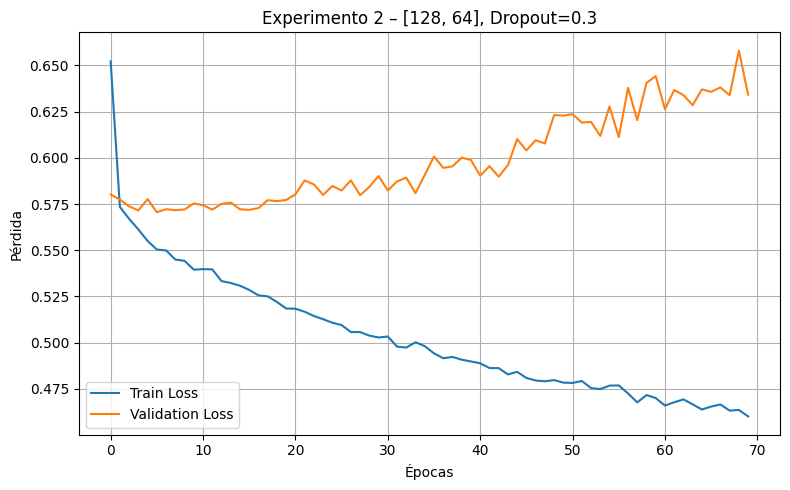


=== Experimento 3 ===
Configuración: {'hidden_layers': [256, 128, 64], 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.0001, 'epochs': 100}
Epoch 1/100 - Train Loss: 0.6566 | Val Loss: 0.5740
Epoch 10/100 - Train Loss: 0.5463 | Val Loss: 0.5763
Epoch 20/100 - Train Loss: 0.5267 | Val Loss: 0.5735
Epoch 30/100 - Train Loss: 0.5143 | Val Loss: 0.5937
Epoch 40/100 - Train Loss: 0.4997 | Val Loss: 0.6013
Epoch 50/100 - Train Loss: 0.4882 | Val Loss: 0.6202
Epoch 60/100 - Train Loss: 0.4790 | Val Loss: 0.6164
Epoch 70/100 - Train Loss: 0.4720 | Val Loss: 0.6362
Epoch 80/100 - Train Loss: 0.4682 | Val Loss: 0.6423
Epoch 90/100 - Train Loss: 0.4652 | Val Loss: 0.6779
Epoch 100/100 - Train Loss: 0.4544 | Val Loss: 0.6861


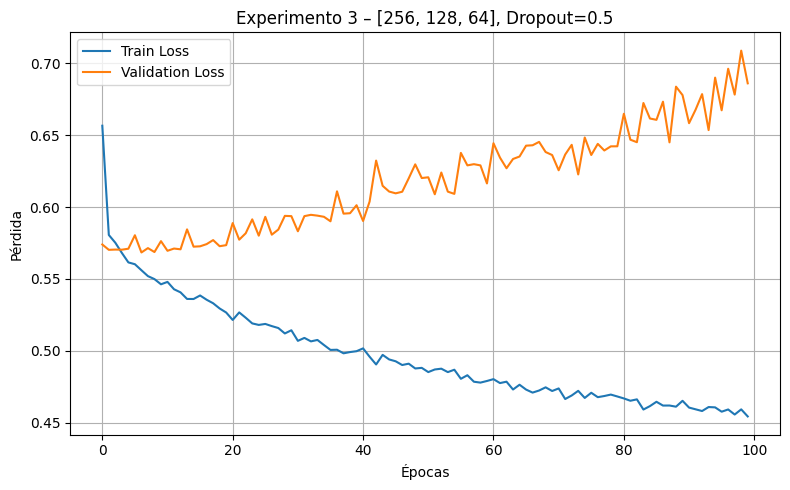


=== Experimento 4 ===
Configuración: {'hidden_layers': [512, 256], 'dropout': 0.4, 'lr': 0.0005, 'weight_decay': 0.001, 'epochs': 120}
Epoch 1/120 - Train Loss: 0.6282 | Val Loss: 0.5749
Epoch 10/120 - Train Loss: 0.5496 | Val Loss: 0.5692
Epoch 20/120 - Train Loss: 0.5378 | Val Loss: 0.5700
Epoch 30/120 - Train Loss: 0.5246 | Val Loss: 0.5682
Epoch 40/120 - Train Loss: 0.5177 | Val Loss: 0.5745
Epoch 50/120 - Train Loss: 0.5073 | Val Loss: 0.5738
Epoch 60/120 - Train Loss: 0.4980 | Val Loss: 0.5774
Epoch 70/120 - Train Loss: 0.4924 | Val Loss: 0.5784
Epoch 80/120 - Train Loss: 0.4874 | Val Loss: 0.5963
Epoch 90/120 - Train Loss: 0.4810 | Val Loss: 0.5786
Epoch 100/120 - Train Loss: 0.4800 | Val Loss: 0.5810
Epoch 110/120 - Train Loss: 0.4694 | Val Loss: 0.5974
Epoch 120/120 - Train Loss: 0.4692 | Val Loss: 0.5891


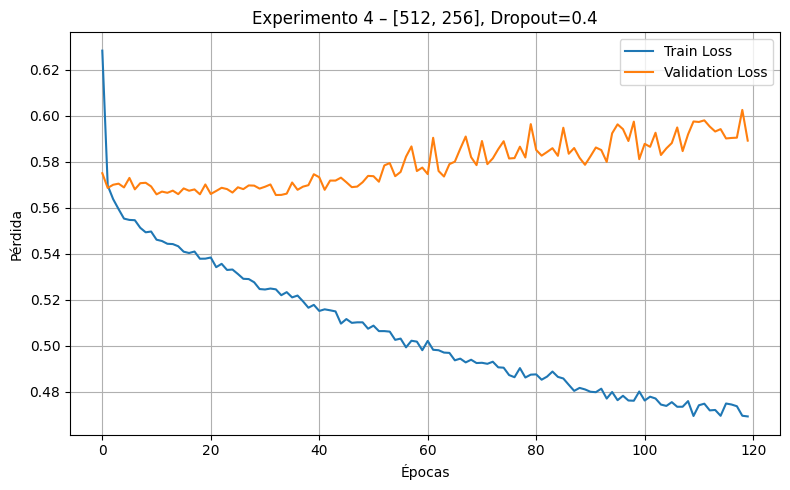


=== Experimento 5 ===
Configuración: {'hidden_layers': [128, 128, 128], 'dropout': 0.2, 'lr': 0.001, 'weight_decay': 0.0, 'epochs': 80}
Epoch 1/80 - Train Loss: 0.6317 | Val Loss: 0.5822
Epoch 10/80 - Train Loss: 0.5228 | Val Loss: 0.5824
Epoch 20/80 - Train Loss: 0.4830 | Val Loss: 0.6486
Epoch 30/80 - Train Loss: 0.4500 | Val Loss: 0.7636
Epoch 40/80 - Train Loss: 0.4293 | Val Loss: 0.8093
Epoch 50/80 - Train Loss: 0.4193 | Val Loss: 0.8253
Epoch 60/80 - Train Loss: 0.4050 | Val Loss: 0.8639
Epoch 70/80 - Train Loss: 0.3871 | Val Loss: 0.9952
Epoch 80/80 - Train Loss: 0.3814 | Val Loss: 0.9517


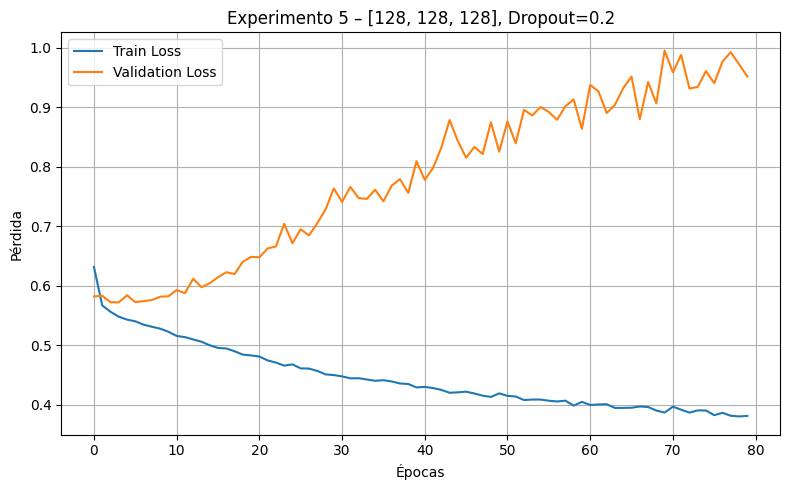

In [ ]:
# Punto 2.2.4 – Experimentos con configuraciones de hiperparámetros

import matplotlib.pyplot as plt

# Función auxiliar para graficar la evolución del loss
def plot_history(history, title="Training Loss"):
    plt.figure(figsize=(8, 5))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Lista de configuraciones de prueba
experiments = [
    # 1. Modelo pequeño, sin regularización
    {"hidden_layers": [64], "dropout": 0.0, "lr": 1e-3, "weight_decay": 0.0, "epochs": 50},

    # 2. Modelo mediano con regularización leve
    {"hidden_layers": [128, 64], "dropout": 0.3, "lr": 1e-3, "weight_decay": 1e-4, "epochs": 70},

    # 3. Modelo grande con regularización fuerte
    {"hidden_layers": [256, 128, 64], "dropout": 0.5, "lr": 1e-3, "weight_decay": 1e-4, "epochs": 100},

    # 4. Modelo ancho, learning rate más bajo
    {"hidden_layers": [512, 256], "dropout": 0.4, "lr": 5e-4, "weight_decay": 1e-3, "epochs": 120},

    # 5. Modelo profundo con capas simétricas
    {"hidden_layers": [128, 128, 128], "dropout": 0.2, "lr": 1e-3, "weight_decay": 0.0, "epochs": 80},
]

# Guardar resultados para análisis posterior
results = []

for i, cfg in enumerate(experiments, 1):
    print(f"\n=== Experimento {i} ===")
    print(f"Configuración: {cfg}")

    # Inicializar modelo y optimizador según los hiperparámetros
    model = MLP(input_dim, hidden_layers=cfg["hidden_layers"], dropout=cfg["dropout"]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])

    # Entrenar modelo
    history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=cfg["epochs"])

    # Almacenar resultados
    results.append((cfg, history))

    # Graficar curvas de pérdida
    plot_history(history, title=f"Experimento {i} – {cfg['hidden_layers']}, Dropout={cfg['dropout']}")


In [ ]:
# Punto 2.2.5 – Implementación de Dropout y EarlyStopping

import numpy as np

# ---------------------------
# Clase de EarlyStopping
# ---------------------------
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        """
        Detiene el entrenamiento si la pérdida de validación no mejora
        después de 'patience' épocas consecutivas.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0
        self.stop = False

    def __call__(self, current_val_loss):
        if current_val_loss < self.best_loss - self.min_delta:
            self.best_loss = current_val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

# ---------------------------
# Función de entrenamiento con EarlyStopping
# ---------------------------
def train_model(
    model, criterion, optimizer,
    train_loader, val_loader,
    epochs=100, patience=10
):
    history = {"train_loss": [], "val_loss": []}
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(1, epochs + 1):
        # ---- Fase de entrenamiento ----
        model.train()
        train_losses = []

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        # ---- Fase de validación ----
        model.eval()
        val_losses = []

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                val_losses.append(loss.item())

        # ---- Guardar historial ----
        avg_train_loss = np.mean(train_losses)
        avg_val_loss = np.mean(val_losses)

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)

        print(f"Epoch {epoch}/{epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # ---- Verificar criterio de parada temprana ----
        early_stopping(avg_val_loss)
        if early_stopping.stop:
            print(f"⏹️ Early stopping activado en la epoch {epoch}")
            break

    return history



=== Experimento 1 ===
Configuración: {'hidden_layers': [128, 64], 'dropout': 0.4, 'lr': 0.001, 'weight_decay': 0.0001, 'epochs': 100}
Epoch 1/100 - Train Loss: 0.6576 | Val Loss: 0.5777
Epoch 2/100 - Train Loss: 0.5736 | Val Loss: 0.5760
Epoch 3/100 - Train Loss: 0.5683 | Val Loss: 0.5726
Epoch 4/100 - Train Loss: 0.5632 | Val Loss: 0.5716
Epoch 5/100 - Train Loss: 0.5590 | Val Loss: 0.5705
Epoch 6/100 - Train Loss: 0.5534 | Val Loss: 0.5692
Epoch 7/100 - Train Loss: 0.5528 | Val Loss: 0.5675
Epoch 8/100 - Train Loss: 0.5509 | Val Loss: 0.5667
Epoch 9/100 - Train Loss: 0.5465 | Val Loss: 0.5719
Epoch 10/100 - Train Loss: 0.5438 | Val Loss: 0.5714
Epoch 11/100 - Train Loss: 0.5456 | Val Loss: 0.5695
Epoch 12/100 - Train Loss: 0.5413 | Val Loss: 0.5727
Epoch 13/100 - Train Loss: 0.5403 | Val Loss: 0.5712
Epoch 14/100 - Train Loss: 0.5390 | Val Loss: 0.5693
Epoch 15/100 - Train Loss: 0.5364 | Val Loss: 0.5690
Epoch 16/100 - Train Loss: 0.5343 | Val Loss: 0.5729
Epoch 17/100 - Train Loss:

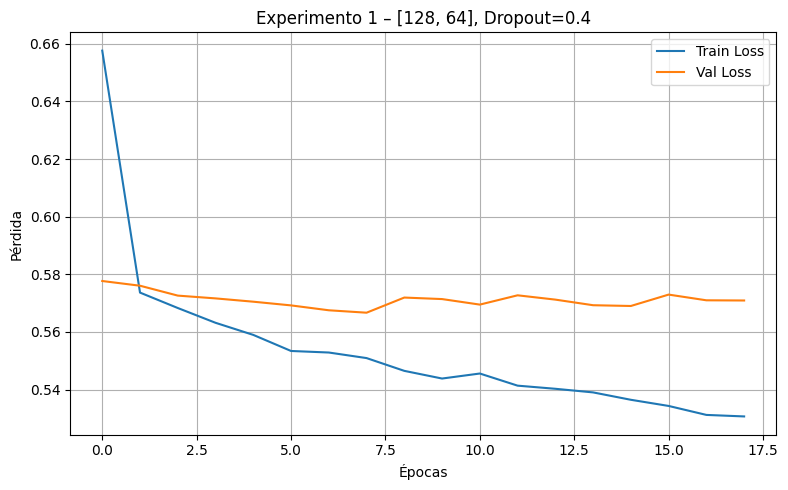

📈 Nuevo mejor modelo encontrado (Val Loss: 0.5667)

=== Experimento 2 ===
Configuración: {'hidden_layers': [256, 128, 64], 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.0001, 'epochs': 120}
Epoch 1/120 - Train Loss: 0.6609 | Val Loss: 0.5780
Epoch 2/120 - Train Loss: 0.5820 | Val Loss: 0.5690
Epoch 3/120 - Train Loss: 0.5693 | Val Loss: 0.5691
Epoch 4/120 - Train Loss: 0.5662 | Val Loss: 0.5705
Epoch 5/120 - Train Loss: 0.5626 | Val Loss: 0.5722
Epoch 6/120 - Train Loss: 0.5606 | Val Loss: 0.5672
Epoch 7/120 - Train Loss: 0.5570 | Val Loss: 0.5695
Epoch 8/120 - Train Loss: 0.5576 | Val Loss: 0.5686
Epoch 9/120 - Train Loss: 0.5527 | Val Loss: 0.5682
Epoch 10/120 - Train Loss: 0.5483 | Val Loss: 0.5691
Epoch 11/120 - Train Loss: 0.5454 | Val Loss: 0.5675
Epoch 12/120 - Train Loss: 0.5414 | Val Loss: 0.5714
Epoch 13/120 - Train Loss: 0.5453 | Val Loss: 0.5756
Epoch 14/120 - Train Loss: 0.5398 | Val Loss: 0.5706
Epoch 15/120 - Train Loss: 0.5368 | Val Loss: 0.5733
Epoch 16/120 - Train Lo

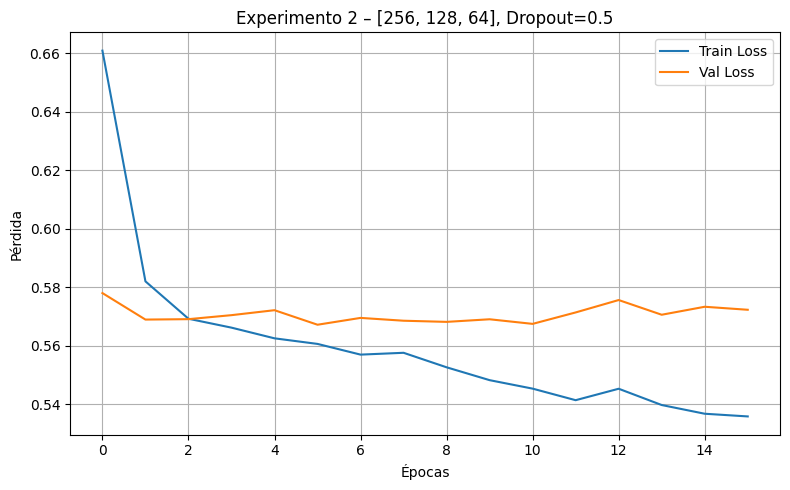


=== Experimento 3 ===
Configuración: {'hidden_layers': [512, 256], 'dropout': 0.6, 'lr': 0.0005, 'weight_decay': 0.001, 'epochs': 150}
Epoch 1/150 - Train Loss: 0.6502 | Val Loss: 0.5789
Epoch 2/150 - Train Loss: 0.5797 | Val Loss: 0.5732
Epoch 3/150 - Train Loss: 0.5691 | Val Loss: 0.5702
Epoch 4/150 - Train Loss: 0.5684 | Val Loss: 0.5717
Epoch 5/150 - Train Loss: 0.5631 | Val Loss: 0.5694
Epoch 6/150 - Train Loss: 0.5608 | Val Loss: 0.5687
Epoch 7/150 - Train Loss: 0.5620 | Val Loss: 0.5686
Epoch 8/150 - Train Loss: 0.5597 | Val Loss: 0.5676
Epoch 9/150 - Train Loss: 0.5569 | Val Loss: 0.5727
Epoch 10/150 - Train Loss: 0.5561 | Val Loss: 0.5689
Epoch 11/150 - Train Loss: 0.5561 | Val Loss: 0.5685
Epoch 12/150 - Train Loss: 0.5540 | Val Loss: 0.5665
Epoch 13/150 - Train Loss: 0.5519 | Val Loss: 0.5674
Epoch 14/150 - Train Loss: 0.5523 | Val Loss: 0.5699
Epoch 15/150 - Train Loss: 0.5520 | Val Loss: 0.5674
Epoch 16/150 - Train Loss: 0.5497 | Val Loss: 0.5702
Epoch 17/150 - Train Loss

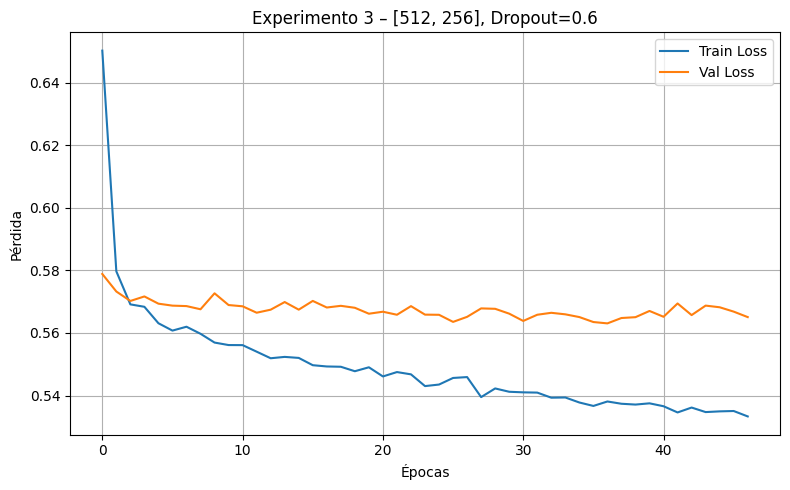

📈 Nuevo mejor modelo encontrado (Val Loss: 0.5631)

=== Experimento 4 ===
Configuración: {'hidden_layers': [64, 32], 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05, 'epochs': 80}
Epoch 1/80 - Train Loss: 0.6877 | Val Loss: 0.5848
Epoch 2/80 - Train Loss: 0.5815 | Val Loss: 0.5769
Epoch 3/80 - Train Loss: 0.5741 | Val Loss: 0.5726
Epoch 4/80 - Train Loss: 0.5647 | Val Loss: 0.5715
Epoch 5/80 - Train Loss: 0.5662 | Val Loss: 0.5781
Epoch 6/80 - Train Loss: 0.5596 | Val Loss: 0.5705
Epoch 7/80 - Train Loss: 0.5568 | Val Loss: 0.5739
Epoch 8/80 - Train Loss: 0.5535 | Val Loss: 0.5738
Epoch 9/80 - Train Loss: 0.5539 | Val Loss: 0.5724
Epoch 10/80 - Train Loss: 0.5484 | Val Loss: 0.5757
Epoch 11/80 - Train Loss: 0.5481 | Val Loss: 0.5704
Epoch 12/80 - Train Loss: 0.5443 | Val Loss: 0.5710
Epoch 13/80 - Train Loss: 0.5463 | Val Loss: 0.5755
Epoch 14/80 - Train Loss: 0.5434 | Val Loss: 0.5731
Epoch 15/80 - Train Loss: 0.5436 | Val Loss: 0.5745
Epoch 16/80 - Train Loss: 0.5392 | Val Loss: 0

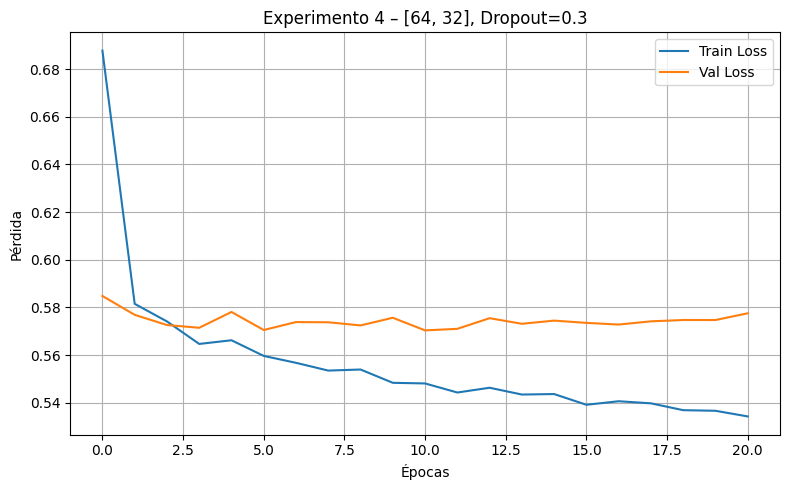


=== Experimento 5 ===
Configuración: {'hidden_layers': [64], 'dropout': 0.4, 'lr': 0.001, 'weight_decay': 0.0001, 'epochs': 50}
Epoch 1/50 - Train Loss: 0.6870 | Val Loss: 0.5899
Epoch 2/50 - Train Loss: 0.5842 | Val Loss: 0.5785
Epoch 3/50 - Train Loss: 0.5733 | Val Loss: 0.5758
Epoch 4/50 - Train Loss: 0.5696 | Val Loss: 0.5746
Epoch 5/50 - Train Loss: 0.5676 | Val Loss: 0.5735
Epoch 6/50 - Train Loss: 0.5643 | Val Loss: 0.5715
Epoch 7/50 - Train Loss: 0.5616 | Val Loss: 0.5714
Epoch 8/50 - Train Loss: 0.5595 | Val Loss: 0.5726
Epoch 9/50 - Train Loss: 0.5598 | Val Loss: 0.5703
Epoch 10/50 - Train Loss: 0.5581 | Val Loss: 0.5694
Epoch 11/50 - Train Loss: 0.5571 | Val Loss: 0.5695
Epoch 12/50 - Train Loss: 0.5561 | Val Loss: 0.5716
Epoch 13/50 - Train Loss: 0.5529 | Val Loss: 0.5689
Epoch 14/50 - Train Loss: 0.5521 | Val Loss: 0.5689
Epoch 15/50 - Train Loss: 0.5540 | Val Loss: 0.5688
Epoch 16/50 - Train Loss: 0.5520 | Val Loss: 0.5686
Epoch 17/50 - Train Loss: 0.5500 | Val Loss: 0.5

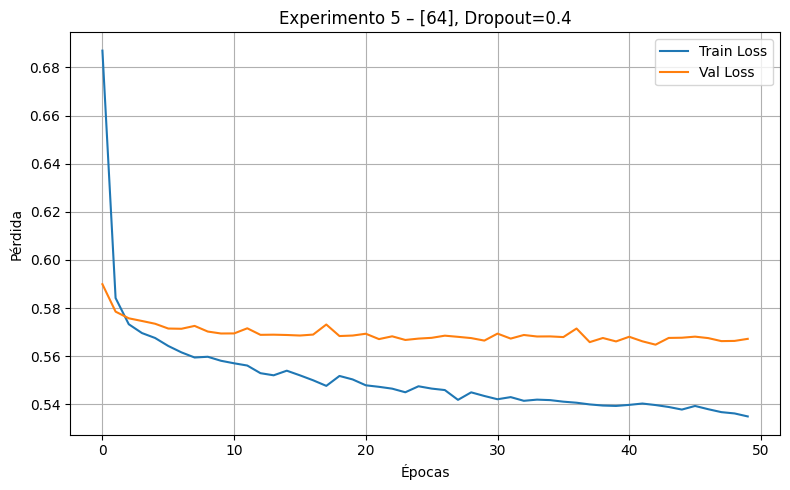


✅ Entrenamiento finalizado.
Mejor configuración encontrada:
{'hidden_layers': [512, 256], 'dropout': 0.6, 'lr': 0.0005, 'weight_decay': 0.001, 'epochs': 150}
Menor pérdida de validación: 0.5631


In [ ]:
# Punto 2.2.6 – Nuevos experimentos con regularización + EarlyStopping

import matplotlib.pyplot as plt

# Función para graficar el historial de pérdidas
def plot_history(history, title="Training Curve"):
    plt.figure(figsize=(8, 5))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Configuraciones de hiperparámetros a probar
experiments = [
    {"hidden_layers": [128, 64],       "dropout": 0.4, "lr": 1e-3, "weight_decay": 1e-4, "epochs": 100},
    {"hidden_layers": [256, 128, 64],  "dropout": 0.5, "lr": 1e-3, "weight_decay": 1e-4, "epochs": 120},
    {"hidden_layers": [512, 256],      "dropout": 0.6, "lr": 5e-4, "weight_decay": 1e-3, "epochs": 150},
    {"hidden_layers": [64, 32],        "dropout": 0.3, "lr": 1e-3, "weight_decay": 1e-5, "epochs": 80},
    {"hidden_layers": [64],            "dropout": 0.4, "lr": 1e-3, "weight_decay": 1e-4, "epochs": 50},
]

# Resultados y seguimiento del mejor modelo
results = []
best_model = None
best_val_loss = np.inf
best_cfg = None

for i, cfg in enumerate(experiments, start=1):
    print(f"\n=== Experimento {i} ===")
    print(f"Configuración: {cfg}")

    # Crear modelo y optimizador
    model = MLP(input_dim, hidden_layers=cfg["hidden_layers"], dropout=cfg["dropout"]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])

    # Entrenar modelo con early stopping
    history = train_model(
        model, criterion, optimizer, train_loader, val_loader,
        epochs=cfg["epochs"], patience=10
    )

    # Almacenar resultados
    results.append((cfg, history))

    # Graficar curvas de pérdida
    plot_history(history, title=f"Experimento {i} – {cfg['hidden_layers']}, Dropout={cfg['dropout']}")

    # Actualizar mejor modelo si corresponde
    current_min_val_loss = min(history["val_loss"])
    if current_min_val_loss < best_val_loss:
        best_val_loss = current_min_val_loss
        best_model = model
        best_cfg = cfg
        print(f"📈 Nuevo mejor modelo encontrado (Val Loss: {best_val_loss:.4f})")

# Mostrar resumen del mejor modelo
print("\n✅ Entrenamiento finalizado.")
print(f"Mejor configuración encontrada:\n{best_cfg}")
print(f"Menor pérdida de validación: {best_val_loss:.4f}")




In [ ]:
# Punto 2.2.7 – Evaluación del mejor modelo con métricas de clasificación binaria

from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score
)

def evaluate_model(model, X, y, set_name="Test"):
    """
    Evalúa un modelo entrenado sobre un conjunto (X, y)
    y muestra métricas de clasificación binaria.
    """
    model.eval()

    # Convertir datos a tensores y enviar al dispositivo
    X_tensor = torch.from_numpy(X).to(device)
    y_tensor = torch.from_numpy(y).to(device)

    with torch.no_grad():
        logits = model(X_tensor)
        probs = torch.sigmoid(logits).cpu().numpy()  # Probabilidades [0,1]
        preds = (probs >= 0.5).astype(int)            # Clasificación binaria

    # Calcular métricas
    acc  = accuracy_score(y, preds)
    prec = precision_score(y, preds, zero_division=0)
    rec  = recall_score(y, preds, zero_division=0)
    f1   = f1_score(y, preds, zero_division=0)
    auc  = roc_auc_score(y, probs)

    # Mostrar métricas
    print(f"\n📊 Métricas en conjunto '{set_name}':")
    print(f"Accuracy:   {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall:     {rec:.4f}")
    print(f"F1-score:   {f1:.4f}")
    print(f"ROC AUC:    {auc:.4f}")

    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc}

# Evaluación del mejor modelo en los tres conjuntos
train_metrics = evaluate_model(best_model, X_train, y_train, "Train")
val_metrics   = evaluate_model(best_model, X_val,   y_val,   "Validation")
test_metrics  = evaluate_model(best_model, X_test,  y_test,  "Test")



📊 Métricas en conjunto 'Train':
Accuracy:   0.8274
Precision:  0.5946
Recall:     0.8901
F1-score:   0.7129
ROC AUC:    0.9277

📊 Métricas en conjunto 'Validation':
Accuracy:   0.8104
Precision:  0.5654
Recall:     0.8539
F1-score:   0.6803
ROC AUC:    0.9091

📊 Métricas en conjunto 'Test':
Accuracy:   0.8111
Precision:  0.5655
Recall:     0.8638
F1-score:   0.6835
ROC AUC:    0.9143
